## Final Project Submission

Please fill out:
* Student name: Matthew Sparr
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli 
* Blog post URL:

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os
import json
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score

## Introduction

## Grab train and test set

In [2]:
train = pd.read_csv('train/train.csv')
test = pd.read_csv('test/test.csv')

## Fill missing values

In [52]:
train.isna().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [53]:
test.isna().sum()

Type              0
Name            303
Age               0
Breed1            0
Breed2            0
Gender            0
Color1            0
Color2            0
Color3            0
MaturitySize      0
FurLength         0
Vaccinated        0
Dewormed          0
Sterilized        0
Health            0
Quantity          0
Fee               0
State             0
RescuerID         0
VideoAmt          0
Description       2
PetID             0
PhotoAmt          0
dtype: int64

In [3]:
train.Name.fillna(' ', inplace=True)
train.Description.fillna(' ', inplace=True)

test.Name.fillna(' ', inplace=True)
test.Description.fillna(' ', inplace=True)

## Explore variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B97C1FBF28>,
      dtype=object)

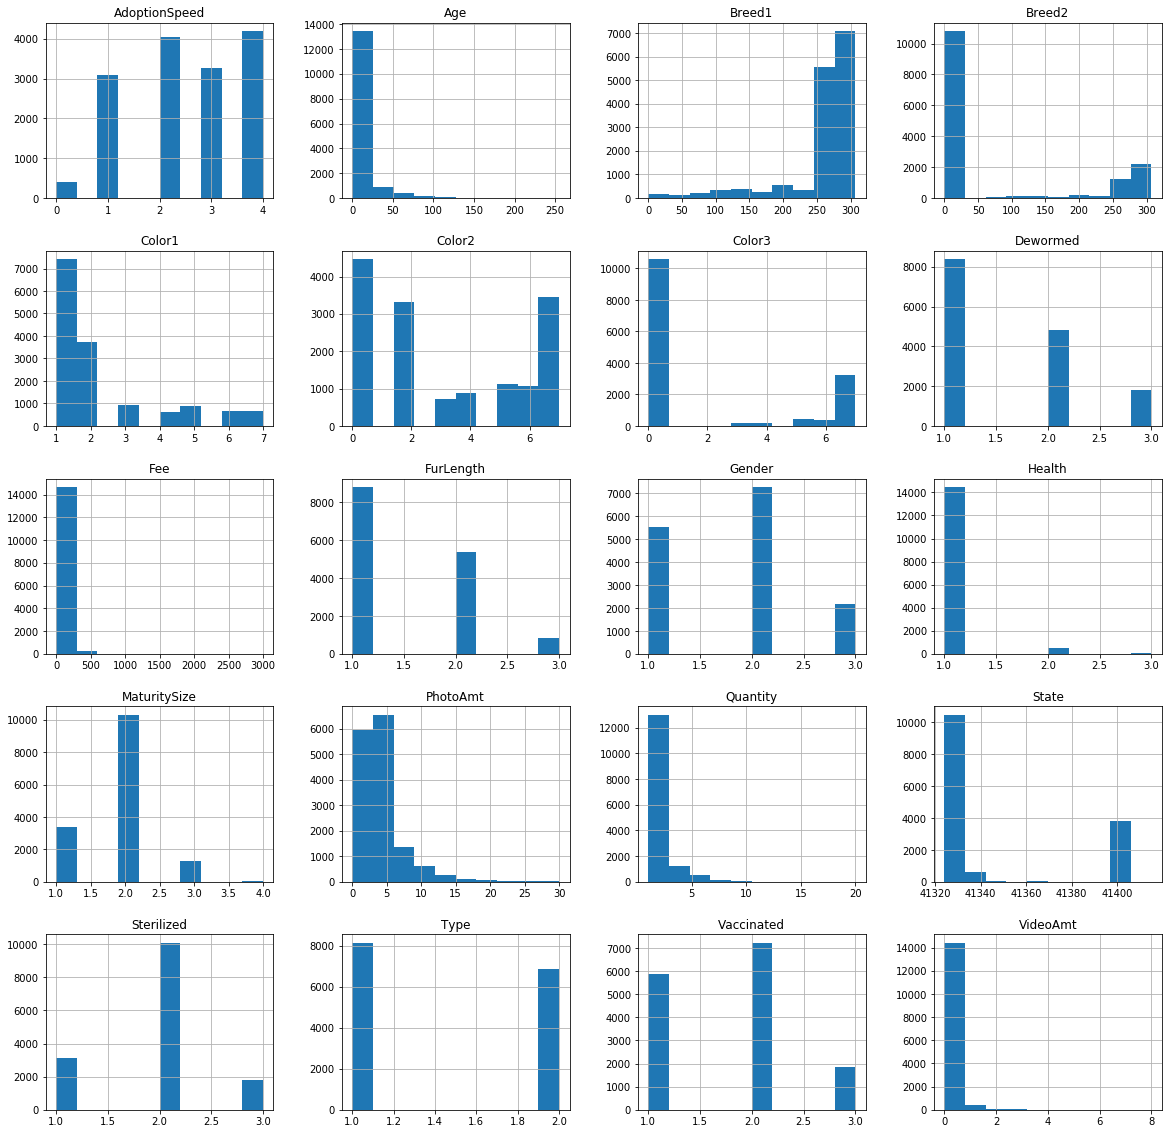

In [55]:
train.hist(figsize=(20,20))

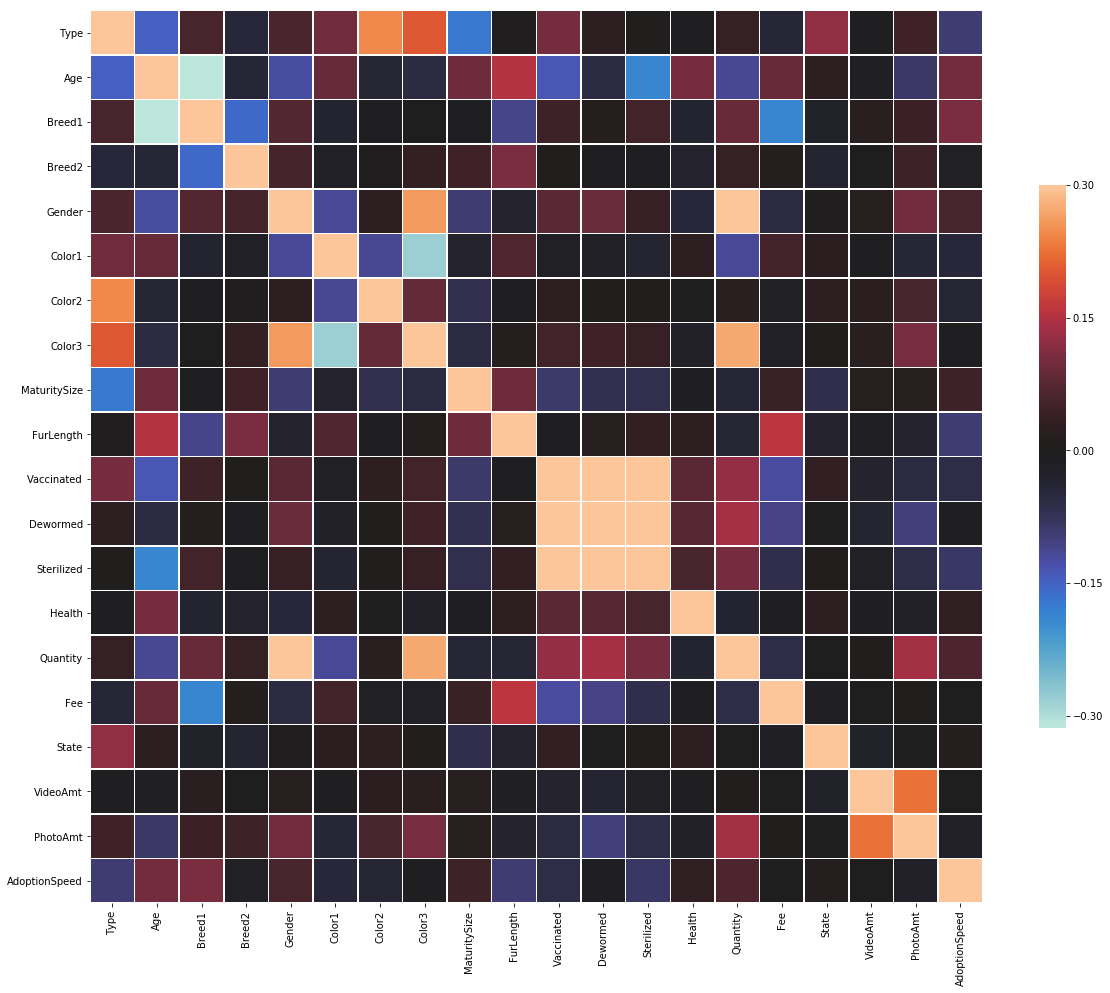

In [56]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train.corr(),vmax=.3, center=0,
            square=True, linewidths=.5,cbar_kws={"shrink": .5})

In [57]:
train.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[0:10]

AdoptionSpeed  AdoptionSpeed    1.000000
Vaccinated     Dewormed         0.722596
Gender         Quantity         0.494489
Vaccinated     Sterilized       0.471204
Dewormed       Sterilized       0.426256
Breed1         Age              0.314346
Color1         Color3           0.282897
Quantity       Color3           0.272548
Color3         Gender           0.259309
Type           Color2           0.246333
dtype: float64

In [58]:
train.Type.value_counts()
# 1 == Dog, 2 == Cat

1    8132
2    6861
Name: Type, dtype: int64

In [10]:
train.Breed1.value_counts().head(15)

307    5927
266    3634
265    1258
299     342
264     296
292     264
285     221
141     205
205     190
179     167
218     162
109     151
254     105
103      98
243      94
Name: Breed1, dtype: int64

In [11]:
train.Breed2.value_counts().head(15)

0      10762
307     1727
266      599
265      321
299      138
264      125
292      105
218       91
141       86
285       78
103       55
213       49
254       42
189       40
109       39
Name: Breed2, dtype: int64

In [12]:
train.Gender.value_counts()

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

Text(0,0.5,'Average Age')

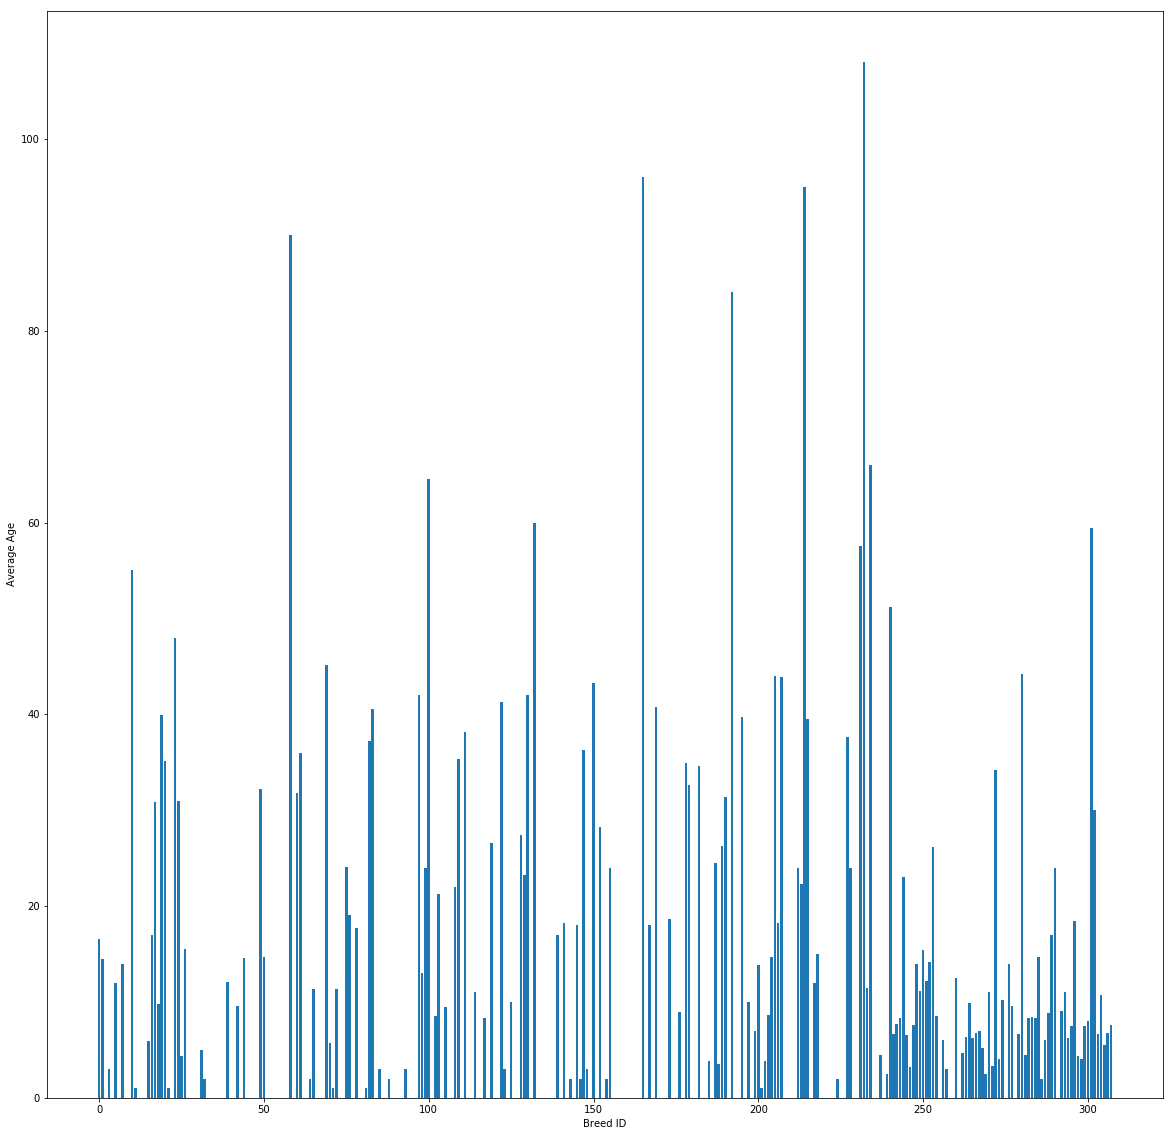

In [13]:
x = train.Breed1.unique()
y = []
for i in x:
    y.append(train.Age[train.Breed1 == i].mean())
breed_vs_age = pd.DataFrame()
breed_vs_age['Breed'] = x
breed_vs_age['Age'] = y
breed_vs_age.sort_values('Age', inplace=True)
breed_vs_age.head()
f, ax = plt.subplots(figsize=(20, 20))
plt.bar(breed_vs_age['Breed'], breed_vs_age['Age'])
plt.xlabel('Breed ID')
plt.ylabel('Average Age')

## Add image metadata

In [65]:
for index, row in train.iterrows():
    file = 'train_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        train.loc[index, 'vertex_x']= vertex_x
        train.loc[index, 'vertex_y']= vertex_y
        train.loc[index, 'bounding_conf']= bounding_confidence
        train.loc[index, 'bounding_imp']= bounding_importance_frac
        train.loc[index, 'dom_blue']= dominant_blue
        train.loc[index, 'dom_green']= dominant_green
        train.loc[index, 'dom_red']= dominant_red
        train.loc[index, 'pixel_frac']= dominant_pixel_frac
        train.loc[index, 'score']= dominant_score
    else:
        train.loc[index, 'vertex_x']= -1
        train.loc[index, 'vertex_y']= -1
        train.loc[index, 'bounding_conf']= -1
        train.loc[index, 'bounding_imp']= -1
        train.loc[index, 'dom_blue']= -1
        train.loc[index, 'dom_green']= -1
        train.loc[index, 'dom_red']= -1
        train.loc[index, 'pixel_frac']= -1
        train.loc[index, 'score']= -1

In [66]:
for index, row in test.iterrows():
    file = 'test_metadata/' + row['PetID'] + '-1.json'
    if os.path.exists(file):
        data = json.load(open(file, encoding="utf8"))
        vertex_x = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['x']
        vertex_y = data['cropHintsAnnotation']['cropHints'][0]['boundingPoly']['vertices'][2]['y']
        bounding_confidence = data['cropHintsAnnotation']['cropHints'][0]['confidence']
        bounding_importance_frac = data['cropHintsAnnotation']['cropHints'][0].get('importanceFraction', -1)
        dominant_blue = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['blue']
        dominant_green = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['green']
        dominant_red = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['color']['red']
        dominant_pixel_frac = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['pixelFraction']
        dominant_score = data['imagePropertiesAnnotation']['dominantColors']['colors'][0]['score']
        test.loc[index, 'vertex_x']= vertex_x
        test.loc[index, 'vertex_y']= vertex_y
        test.loc[index, 'bounding_conf']= bounding_confidence
        test.loc[index, 'bounding_imp']= bounding_importance_frac
        test.loc[index, 'dom_blue']= dominant_blue
        test.loc[index, 'dom_green']= dominant_green
        test.loc[index, 'dom_red']= dominant_red
        test.loc[index, 'pixel_frac']= dominant_pixel_frac
        test.loc[index, 'score']= dominant_score
    else:
        test.loc[index, 'vertex_x']= -1
        test.loc[index, 'vertex_y']= -1
        test.loc[index, 'bounding_conf']= -1
        test.loc[index, 'bounding_imp']= -1
        test.loc[index, 'dom_blue']= -1
        test.loc[index, 'dom_green']= -1
        test.loc[index, 'dom_red']= -1
        test.loc[index, 'pixel_frac']= -1
        test.loc[index, 'score']= -1

## Add name and description length

In [67]:
train['NameLength'] = train['Name'].map(lambda x: 0 if x == 'None' else len(x)).astype('int')
train['DescLength'] = train['Description'].map(lambda x: len(x)).astype('int')
test['NameLength'] = test['Name'].map(lambda x: 0 if x == 'None' else len(x)).astype('int')
test['DescLength'] = test['Description'].map(lambda x: len(x)).astype('int')

## Add dog data

In [5]:
dog_data = pd.read_csv('dog_breeds.csv')

In [6]:
dog_data.head()

,Unnamed: 0,BreedID,Type,BreedName,Group
0,0,1,1,Affenpinscher,Toy
1,1,2,1,Afghan Hound,Hound
2,2,3,1,Airedale Terrier,Terrier
3,3,4,1,Akbash,Working
4,4,5,1,Akita,Working


In [255]:
for index, row in train.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            train.at[index,'Group'] = r['Group']
            break

In [ ]:
for index, row in test.iterrows():
    for i, r in dog_data.iterrows():
        if row['Breed1'] == r['BreedID']:
            test.at[index,'Group'] = r['Group']
            break

In [ ]:
train.Group.isna().sum()

In [25]:
dog_data.columns

Index(['Unnamed: 0', 'BreedID', 'Type', 'BreedName', 'Group'], dtype='object')

In [37]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    train.loc[index,'Group'] = group    

In [42]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        group = dog_data[dog_data['BreedID'] == breed]['Group'].values[0]
    except:
        group = 'Cat'
    test.loc[index,'Group'] = group 

In [38]:
train.Group.value_counts()

Cat             6853
Misc            6018
Sporting         448
Toy              409
Working          366
Terrier          311
Non-Sporting     247
Herding          168
Hound            155
FSS               13
Hunting            5
Name: Group, dtype: int64

In [43]:
test.Group.value_counts()

Cat             2072
Misc            1323
Toy              125
Sporting         110
Working          101
Non-Sporting      70
Terrier           65
Herding           44
Hound             37
FSS                1
Name: Group, dtype: int64

## Add cat data

In [46]:
cat_data = pd.read_csv('cat_info.csv')

In [47]:
cat_data.head()

,BreedID,Type,BreedName,Cute,Hypo
0,241,2,Abyssinian,0,0
1,242,2,American Curl,1,0
2,243,2,American Shorthair,1,0
3,244,2,American Wirehair,0,0
4,245,2,Applehead Siamese,0,0


In [51]:
for index, row in train.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    train.loc[index,'Cat_Cute'] = cute
    train.loc[index,'Cat_Hypo'] = hypo

In [53]:
for index, row in test.iterrows():
    try:
        breed = row['Breed1']
        cute = cat_data[cat_data['BreedID'] == breed]['Cute'].values[0]
        hypo = cat_data[cat_data['BreedID'] == breed]['Hypo'].values[0]
    except:
        cute = -1
        hypo = -1
    test.loc[index,'Cat_Cute'] = cute
    test.loc[index,'Cat_Hypo'] = hypo

In [50]:
train.Cat_Cute.value_counts()

-1.0    8145
 0.0    6404
 1.0     444
Name: Cat_Cute, dtype: int64

In [52]:
train.Cat_Hypo.value_counts()

-1.0    8145
 0.0    6350
 1.0     498
Name: Cat_Hypo, dtype: int64

In [54]:
test.Cat_Cute.value_counts()

 0.0    1952
-1.0    1876
 1.0     120
Name: Cat_Cute, dtype: int64

In [55]:
test.Cat_Hypo.value_counts()

 0.0    1948
-1.0    1876
 1.0     124
Name: Cat_Hypo, dtype: int64

## Add state data

In [59]:
state_data = pd.read_csv('state_data.csv')
state_data.head()

,State,Population,StateID,UrbanPercent,PopDensity
0,Kuala Lumpur,1627172,41401,100.0,6891
1,Labuan,86908,41415,82.3,950
2,Johor,3348283,41336,71.9,174
3,Kedah,1890098,41325,64.6,199
4,Kelantan,1459994,41367,42.4,97


In [60]:
for index, row in train.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    train.loc[index,'UrbanPercent'] = urban
    train.loc[index,'Population'] = pop
    train.loc[index,'PopDensity'] = pop_den

In [62]:
for index, row in test.iterrows():
    state = row['State']
    urban = state_data[state_data['StateID'] == state]['UrbanPercent'].values[0]
    pop = state_data[state_data['StateID'] == state]['Population'].values[0]
    pop_den = state_data[state_data['StateID'] == state]['PopDensity'].values[0]

    test.loc[index,'UrbanPercent'] = urban
    test.loc[index,'Population'] = pop
    test.loc[index,'PopDensity'] = pop_den

In [63]:
train.Population.value_counts()

5411324.0    8714
1627172.0    3845
1520143.0     843
3348283.0     507
2258428.0     420
997071.0      253
788706.0      137
1890098.0     110
1443365.0      85
1015776.0      26
3117405.0      22
1459994.0      15
2420009.0      13
86908.0         3
Name: Population, dtype: int64

In [64]:
test.Population.value_counts()

5411324.0    2018
1627172.0    1279
1520143.0     229
3348283.0     136
2258428.0     104
997071.0       55
788706.0       47
1890098.0      45
2420009.0      22
3117405.0       7
1015776.0       2
1459994.0       2
1443365.0       2
Name: Population, dtype: int64

## Save preprocessed data

In [68]:
train.to_csv('processed_train.csv')
test.to_csv('processed_test.csv')

## Import preprocessed data

In [69]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')

## Encode categorical variables

In [70]:
train = pd.get_dummies(train, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])
test = pd.get_dummies(test, columns = ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                                 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
                                 'State', 'Type', 'Group'
                                ])

## Make sure train and test have same columns

In [71]:
diff_columns = set(train.columns).difference(set(test.columns))
for i in diff_columns:
    test[i] = test.apply(lambda _: 0, axis=1)
diff_columns2 = set(test.columns).difference(set(train.columns))
for i in diff_columns2:
    train[i] = train.apply(lambda _: 0, axis=1)
test = test[train.columns]

In [72]:
train.shape

(14993, 433)

In [73]:
test.shape

(3948, 433)

## Set target variable

In [75]:
target = train['AdoptionSpeed'].astype('int')

## Drop irrelevent columns

In [82]:
X.columns

Index(['Unnamed: 0', 'Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt',
       'NameLength', 'DescLength', 'Cat_Cute', 'Cat_Hypo',
       ...
       'Breed1_6', 'Breed2_165', 'Breed2_51', 'Breed2_233', 'Breed1_278',
       'Breed1_51', 'Breed2_280', 'Breed2_100', 'Breed1_112', 'Breed2_62'],
      dtype='object', length=428)

In [84]:
X = train.drop(['Name', 'RescuerID', 'Description', 'PetID', 'AdoptionSpeed', 'Unnamed: 0'], axis=1)
X_pred = test.drop(['Name', 'RescuerID', 'Description', 'Unnamed: 0'], axis=1)

## Baseline XGBoost

In [85]:
clf = xgb.XGBClassifier()
clf.fit(X, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [86]:
scores = cross_val_score(clf, X, target, cv=2)

In [87]:
scores.mean()

0.4060558288080735

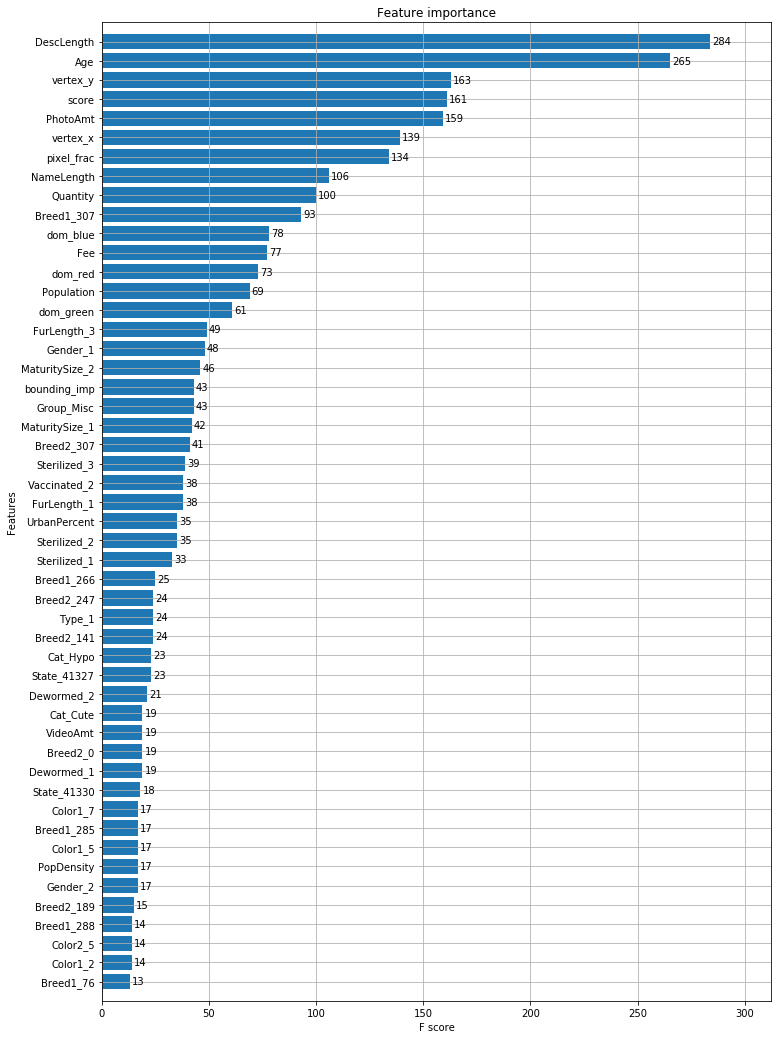

In [88]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [89]:
test_pred = clf.predict(X_pred.drop(['AdoptionSpeed','PetID'], axis=1))

In [90]:
pred = pd.DataFrame()
pred['PetID'] = X_pred['PetID']
pred['AdoptionSpeed'] = test_pred
pred.set_index('PetID').to_csv("submission.csv", index=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC67AF25F8>]],
      dtype=object)

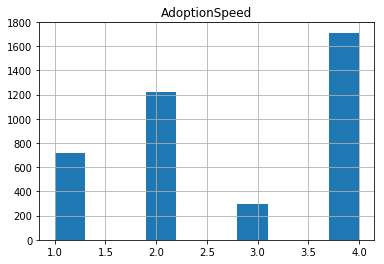

In [91]:
pred.hist()

### This received a score of 0.334 on the Kaggle competition's test data #1

## Dimensionality reduction

## Class imbalance